In [3]:
from torchvision.datasets import VOCDetection

In [17]:
train_dataset = VOCDetection(root="./data",
                             year="2007",
                             download=True,
                             image_set="trainval",
                             transform=None)
test_dataset = VOCDetection(root="./data",
                             year="2007",
                             download=True,
                             image_set="test",
                             transform=None)           

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtest_06-Nov-2007.tar
Extracting ./data/VOCtest_06-Nov-2007.tar to ./data


In [18]:
img, target = train_dataset[1]

In [20]:
target

{'annotation': {'folder': 'VOC2007',
  'filename': '000007.jpg',
  'source': {'database': 'The VOC2007 Database',
   'annotation': 'PASCAL VOC2007',
   'image': 'flickr',
   'flickrid': '194179466'},
  'owner': {'flickrid': 'monsieurrompu', 'name': 'Thom Zemanek'},
  'size': {'width': '500', 'height': '333', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'car',
    'pose': 'Unspecified',
    'truncated': '1',
    'difficult': '0',
    'bndbox': {'xmin': '141', 'ymin': '50', 'xmax': '500', 'ymax': '330'}}]}}

In [23]:
len(test_dataset)

4952

In [85]:
!pip install selectivesearch
import selectivesearch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 3.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 kB 5.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 4.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.9/220.9 kB 4.6 MB/s eta 0:00:00a 0:00:01
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4334 sha256=27048e2df9829c094845b5357f68a8ae45e112ed2ad33874483eff26793a7be4
  Stored in directory: /Users/h383kim/Library/Caches/pip/wheels/66/4e/88/6de23ce74be839a953498c4ebdfa809ad7da9422ac89ae856c
Successfully built selectivesearch


In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.optim as optim
import torchvision
from torchvision import models
import matplotlib.pyplot as plt
#import selective_search

import cv2

import xml.etree.ElementTree as ET
from PIL import Image
import os

In [2]:
import sys

def ss_config(ss, img, mode):
    ss.setBaseImage(img)

    if mode == 's':
        ss.switchToSingleStrategy()
    elif mode == 'f':
        ss.switchToSelectiveSearchFast()
    elif mode == 'q':
        ss.switchToSelectiveSearchQuality()
    else:
        print("Re-enter the mode. s or f or q")
        sys.exit(1)


def selective_search(img, mode='q'):
    # Initiate Selective Search
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    # Configure the mode and image
    ss_config(ss, img, mode)

    # Process Selective-Search
    bboxes = ss.process() # bboxes: listof [x, y, w, h]
    bboxes[:, 2] += bboxes[:, 0] # bboxes -> listof [x, y, x + w, h]
    bboxes[:, 3] += bboxes[:, 1] # bboxes -> listof [x, y, x + w, h + y]

    return bboxes

In [3]:
def parse_xml_boxes(root):
    bboxes=[]
    for obj in root.findall('object'):
        cls_name = obj.find('name').text
        cls_idx = VOC_CLASSES.index(cls_name)
        xmin = int(obj.find('bndbox').find('xmin').text)
        ymin = int(obj.find('bndbox').find('ymin').text)
        xmax = int(obj.find('bndbox').find('xmax').text)
        ymax = int(obj.find('bndbox').find('ymax').text)
        bboxes.append([xmin, ymin, xmax, ymax, cls_idx]) 
    return bboxes

In [4]:
def compute_iou(boxA, boxB):
    # Compute the Intersection over Union (IoU) between two bounding boxes
    xA = max(boxA[0], boxB[0])  # max of xmin
    yA = max(boxA[1], boxB[1])  # max of ymin
    xB = min(boxA[2], boxB[2])  # min of xmax
    yB = min(boxA[3], boxB[3])  # min of ymax

    # Compute the area of the intersection rectangle
    interWidth = max(0, xB - xA + 1)
    interHeight = max(0, yB - yA + 1)
    interArea = interWidth * interHeight

    # Compute the area of both bounding boxes
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the Intersection over Union by dividing the intersection area by the sum of both areas minus the intersection
    iou = interArea / float(boxAArea + boxBArea - interArea) if interArea > 0 else 0.0

    return iou

In [5]:
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 
    'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

In [6]:
class CustomDataset(Dataset):
    def __init__(self, root, img_set='trainval', transform=None):
        self.root = root
        self.transform = transform
        self.img_set = img_set
        
        self.annotation_path = os.path.join(self.root, f'PASCAL_VOC_{self.img_set}', 'VOCdevkit', 'VOC2007', 'Annotations')
        self.img_path = os.path.join(self.root, f'PASCAL_VOC_{self.img_set}', 'VOCdevkit', 'VOC2007', 'JPEGimages')

        self.annotations = [os.path.join(self.annotation_path, xml) for xml in sorted(os.listdir(self.annotation_path)) if not xml.startswith('.')]
        self.images = [os.path.join(self.img_path, xml) for xml in sorted(os.listdir(self.img_path)) if not xml.startswith('.')]
        self.annotations = self.annotations[:10]
        self.images = self.images[:10]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load the image using Pillow
        image = Image.open(self.images[idx])
        image = np.array(image)
        # Load annotation
        tree = ET.parse(self.annotations[idx])
        gt_bboxes_labels = parse_xml_boxes(tree.getroot())
        gt_bboxes_labels = np.array(gt_bboxes_labels)
        bboxes, labels= gt_bboxes_labels[:, :4], gt_bboxes_labels[:, -1]
        # Apply transformation if any
        if self.transform:
            image = self.transform(image)
        # Convert data to tensors
        bboxes = torch.tensor(bboxes).float()
        labels = torch.tensor(labels).long()
        
        return image, bboxes, labels

In [7]:
from torchvision.ops import roi_pool

vgg = models.vgg16_bn(weights="IMAGENET1K_V1", progress=True)

class FastRCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load pre-trained VGG16
        # vgg = models.vgg16(weights="IMAGENET1K_V1")
        # Convolutional layers
        self.features = vgg.features
        # ROI Pooling
        self.roi = roi_pool
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            # nn.Linear(4096, num_classes),
        )
        self.softmax = nn.Linear(4096, num_classes + 1)
        self.bbox = nn.Linear(4096, num_classes * 4)
        
    def forward(self, images, ROIs):
        # Compute feature maps
        feature_maps = self.features(images)
        #print(feature_maps.shape)
        # Apply ROI pooling
        pooled_features = self.roi(feature_maps, ROIs, output_size=(7, 7), spatial_scale=1.0/16.0)
        #print(pooled_features.shape)
        # Flatten pooled features
        x = pooled_features.view(pooled_features.size(0), -1) # .size(0) = Batch Size(N=64)
        # x: [64, 512, 7, 7]
        # Classifier
        x = self.classifier(x) # x: [64, 4096]
        
        # Outputs
        cls_score = self.softmax(x) # (64, num_classes + 1)
        bbox_pred = self.bbox(x) # (64, num_classes * 4)
        
        return cls_score, bbox_pred

In [8]:
import torch.nn.functional as F

class MultiTaskLoss(nn.Module):
    def __init__(self, lambda_reg=1):
        super().__init__()
        self.lambda_reg = lambda_reg
    
    def forward(self, cls_preds, bbox_preds, labels, bbox_targets, POS_NUM, num_classes=20):
        # Cross entropy loss for classification
        classification_loss = F.cross_entropy(cls_preds, labels)
        # Bounding box loss
        '''
        bbox_preds: [64, 20, 4]
        bbox_targets: [len(pos_indices), 4]
        '''
        pos_proposals = list(range(POS_NUM))
        if POS_NUM > 0:
            pos_labels = labels[labels < 20] # Non-background
            bbox_preds = bbox_preds.view(-1, num_classes, 4) # Reshaping bbox_preds from [64, num_classes*4] to [64, num_classes, 4]
            bbox_preds_pos = bbox_preds[pos_proposals, pos_labels, :]
            regression_loss = F.smooth_l1_loss(bbox_preds_pos, bbox_targets)
        else:
            regression_loss = torch.tensor(0.0, requires_grad=True).to(bbox_preds.device)
        
        totalLoss = classification_loss + regression_loss
        return totalLoss

In [9]:
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.transforms import v2

VOC_VAL = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
s = 600

transformation = v2.Compose([
    v2.ToImage(),  # Image to Tensor
    v2.ToDtype(torch.float32, scale=True), # Tensor scaling to [0~1]
    v2.Normalize(mean=VOC_VAL[0], std=VOC_VAL[1]) # Data Normalization
])

root_dir = '/Users/h383kim/pytorch/data'
# Create dataset and dataloader
train_dataset = CustomDataset(root_dir, img_set="trainval", transform=transformation)
test_dataset = CustomDataset(root_dir, img_set="test", transform=transformation)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [10]:
train_dataset[0]

(Image([[[-1.9467, -1.8953, -1.9467,  ...,  0.6734,  0.6563,  0.6392],
         [-2.0665, -1.9980, -1.9295,  ...,  0.6734,  0.6734,  0.6734],
         [-1.3473, -1.7069, -1.8610,  ...,  0.7077,  0.7077,  0.7077],
         ...,
         [-1.5870, -1.5014, -1.6213,  ..., -1.1247, -1.0733, -1.1247],
         [-1.5014, -1.5357, -1.4672,  ..., -0.9877, -0.9192, -0.9192],
         [-1.2788, -1.0904, -0.8678,  ..., -1.0219, -0.9534, -0.9363]],
 
        [[-1.8606, -1.8081, -1.8606,  ...,  1.2556,  1.2381,  1.2206],
         [-1.9657, -1.8782, -1.8431,  ...,  1.2556,  1.2556,  1.2556],
         [-1.1779, -1.5455, -1.7556,  ...,  1.2906,  1.2906,  1.2906],
         ...,
         [-1.8256, -1.7381, -1.8606,  ..., -0.7752, -0.7752, -0.7927],
         [-1.8782, -1.9132, -1.8957,  ..., -0.6352, -0.5826, -0.5826],
         [-1.7381, -1.6506, -1.5980,  ..., -0.6527, -0.5826, -0.5651]],
 
        [[-1.6302, -1.5779, -1.6302,  ...,  1.5942,  1.5768,  1.5594],
         [-1.6999, -1.6650, -1.5779,  ..., 

In [11]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
fastrcnn = FastRCNN(20)
fastrcnn.load_state_dict(torch.load('/Users/h383kim/pytorch/Fast-R-CNN/model_checkpoint.pth', map_location=torch.device('cpu')))
fastrcnn = fastrcnn.to(DEVICE)

/var/folders/n0/q19jqn7s6ts2t70bq5v6mhhc0000gn/T/ipykernel_1060/2092961591.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fastrcnn.load_state_dict(torch.load('/Users/h3

In [12]:
DEVICE

device(type='mps')

In [13]:
def bbox_transform(proposal, gt_box):
    g_xmin, g_ymin, g_w, g_h = gt_box[0], gt_box[1], gt_box[2] - gt_box[0], gt_box[3] - gt_box[1]
    p_xmin, p_ymin, p_w, p_h = proposal[0], proposal[1], proposal[2] - proposal[0], proposal[3] - proposal[1]
    # G_x, G_y, P_x, P_y = Center coordinates of gt_box and proposal
    G_x, G_y = g_xmin + 0.5*g_w, g_ymin + 0.5*g_h
    P_x, P_y = p_xmin + 0.5*p_w, p_ymin + 0.5*p_h
    # target delats(transformations) to be learned
    t_x = (G_x - P_x) / p_w
    t_y = (G_y - P_y) / p_h
    t_w = torch.log(g_w / p_w)
    t_h = torch.log(g_h / p_h)

    return torch.tensor([t_x, t_y, t_w, t_h])

In [14]:
# def ss(img):
#     # Move the tensor to CPU and convert to NumPy array
#     img = img.cpu().numpy()
    
#     labels, regions = selectivesearch.selective_search(img, scale=150, sigma=0.8, min_size=20)
#     bboxes = [region['rect'] for region in regions]
#     bboxes = np.array(bboxes)
#     bboxes[:, 2] += bboxes[:, 0]
#     bboxes[:, 3] += bboxes[:, 1]
#     return bboxes

In [15]:
import random

def sample_proposals(proposals, gt_boxes, gt_labels):
    threshold_up = 0.5
    threshold_low = 0.1
    POS_NUM = 16
    NEG_NUM = 48
    positive_proposals, positive_labels, negative_proposals = [], [], []
    bbox_targets = [] # the target transformation from proposal to gt_bbox
    
    for proposal in proposals:
        best_iou = 0
        best_label = None
        best_gt_box = None
        
        for gt_box, gt_label in zip(gt_boxes, gt_labels):
            iou = compute_iou(proposal, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_label = gt_label
                best_gt_box = gt_box
        # If the proposal has IOU > 0.5
        if best_iou > threshold_up:
            positive_proposals.append(proposal)
            positive_labels.append(best_label)
            # Compute regression targets
            bbox_target = bbox_transform(proposal, best_gt_box)
            bbox_targets.append(bbox_target)
#         # Else if the proposal has 0.1 < IOU <= 0.5
#         elif best_iou > threshold_low:
#             negative_proposals.append(proposal)
#             # Doesn't need to keep track of label, because background label is fixed
#         else:
#             pass
        else:
            negative_proposals.append(proposal)
            
    # Choose ~16 positives and 48 negatives (More negatives if postives is less than 16)
    if len(positive_proposals) < POS_NUM:
        POS_NUM = len(positive_proposals)
        NEG_NUM = (64 - POS_NUM)
    
    pos_indices = random.sample(range(len(positive_proposals)), POS_NUM)
    neg_indices = random.sample(range(len(negative_proposals)), NEG_NUM)
    # Sampling takes place (Replacing the object and all its references if any)
    positive_proposals[:] = [positive_proposals[i] for i in pos_indices]
    positive_labels[:] = [positive_labels[i] for i in pos_indices]
    bbox_targets[:] = [bbox_targets[i] for i in pos_indices]
    negative_proposals[:] = [negative_proposals[i] for i in neg_indices]
    
    total_proposals = positive_proposals + negative_proposals
    total_labels = positive_labels + [20] * NEG_NUM # Background class label as 20
    total_labels = torch.tensor(total_labels, dtype=torch.int64)
    if len(bbox_targets) > 0:
        bbox_targets = torch.stack(bbox_targets)
    else:
        bbox_targets = torch.tensor(bbox_targets)
    return total_proposals, total_labels, bbox_targets, POS_NUM
    

In [16]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    train_loss, correct, train_acc = 0, 0, 0
    total_proposals = 0
    
    #for epoch in range(num_epochs):
    for image, boxes, labels in dataloader:
        image = image.float().to(DEVICE)
        boxes = boxes.to(DEVICE)
        labels = labels.to(DEVICE)

        # Generate ROIs and choose 64 proposals(16 positive + 48 negative)
        #squeezed_img = torch.squeeze(image)
        #ROIs = ss(squeezed_img)
        squeezed_img = torch.squeeze(image)
        ROIs = selective_search(squeezed_img.cpu().numpy())
        '''
        ROIs: total proposals (positive + negative)
        ROI_labels: labels of total proposals
        bbox_targets: target transformations for positive proposals only
        pos_indices: Indices of positive proposals to be used in bbox regression loss
        '''
        boxes = boxes.reshape(-1, 4)
        labels = labels.flatten()
        ROIs, ROI_labels, bbox_targets, POS_NUM = sample_proposals(ROIs, boxes, labels)
        ROIs = torch.tensor(np.array(ROIs)).to(DEVICE) # Converting first into np.array then to Tensor for spped (list -> np.array -> tensor)
        ROI_labels = ROI_labels.to(DEVICE)
        bbox_targets = bbox_targets.to(DEVICE)

        # Forward pass
        image = image.permute(0, 3, 1, 2)
        # ROIs is of shape [K, 4] (without batch index) and batch size is 1
        batch_indices = torch.zeros((ROIs.size(0), 1), device=ROIs.device)  # Batch index 0 for all ROIs
        ROIs_with_batch_index = torch.cat([batch_indices, ROIs], dim=1)  # Concatenate batch index with ROIs
        # ROIs_with_batch_index will have shape [K, 5]
        cls_scores, bbox_preds = model(image, ROIs_with_batch_index)

        # Compute loss
        '''
        cls_scores : [64, num_classes + 1]
        bbox_preds : [64, num_classes * 4]
        ROI_labels : [64, 1]
        bbox_targets : [len(pos_indices), 4]
        '''
        print(POS_NUM)
        loss = loss_fn(cls_scores, bbox_preds, ROI_labels, bbox_targets, POS_NUM)
        train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(cls_scores, dim=1)
        correct += pred.eq(ROI_labels.view_as(pred)).sum().item()
        total_proposals += 64
    
    train_loss /= len(dataloader)
    train_acc = 100. * correct / total_proposals
    return train_loss, train_acc

In [17]:
import time
import copy

loss_lst, acc_lst = [], []
def fine_tune(model: torch.nn.Module, 
              train_dataloader: torch.utils.data.DataLoader, 
              optimizer: torch.optim.Optimizer,
              loss_fn: torch.nn.Module=MultiTaskLoss(),
              num_epochs: int=10):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        # Train the model and print save the results
        train_loss, train_acc = train(model=model,
                                      dataloader=train_dataloader, 
                                      optimizer=optimizer,
                                      loss_fn=loss_fn)
        # Storing loss and acc for the epoch
        loss_lst.append(train_loss)
        acc_lst.append(train_acc)
        
        if train_acc > best_acc:
            best_acc = train_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
        end_time = time.time()
        time_elapsed = end_time - start_time
        print(f"------------ epoch {epoch} ------------")
        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")
        print(f"Time taken: {time_elapsed / 60:.0f}min {time_elapsed % 60:.0f}s")
        
    model.load_state_dict(best_model_wts)
    return model

In [18]:
optimizer = torch.optim.SGD([
    {'params': fastrcnn.features.parameters(), 'lr':1e-4},
    {'params': fastrcnn.classifier.parameters(), 'lr':1e-3},
    {'params': fastrcnn.softmax.parameters(), 'lr':1e-3},
    {'params': fastrcnn.bbox.parameters(), 'lr':1e-3},
], momentum=0.9, weight_decay=0.0005)

In [79]:
fastrcnn_FineTuned = fine_tune(fastrcnn, train_dataloader, optimizer)

16
0
16
0
16
16
0
16
16
0
------------ epoch 1 ------------
Train loss: 0.7620 | Train acc: 85.00%
Time taken: 4min 45s
0
16
0
16
16
0
0
16
16
16
------------ epoch 2 ------------
Train loss: 0.7552 | Train acc: 85.00%
Time taken: 4min 47s
0
16
16
16
0
16
0
16
16
0
------------ epoch 3 ------------
Train loss: 0.7076 | Train acc: 85.16%
Time taken: 4min 48s
0
16
16
0
16
16
16
0
16
0
------------ epoch 4 ------------
Train loss: 0.7148 | Train acc: 85.31%
Time taken: 4min 48s
0
16
0
16
16
16
16
0
16
0
------------ epoch 5 ------------
Train loss: 0.7023 | Train acc: 85.78%
Time taken: 4min 46s
16
16
16
0
0
0
0
16
16
16
------------ epoch 6 ------------
Train loss: 0.6874 | Train acc: 85.47%
Time taken: 4min 46s
16
0
16
16
0
16
0
0
16
16
------------ epoch 7 ------------
Train loss: 0.6534 | Train acc: 85.31%
Time taken: 4min 46s
0
16
16
16
0
16
0
0
16
16
------------ epoch 8 ------------
Train loss: 0.6269 | Train acc: 85.78%
Time taken: 4min 46s
16
16
16
16
0
0
0
16
0
16
------------ e

In [19]:
import pickle as pkl

with open('/Users/h383kim/pytorch/Fast-R-CNN/loss.pkl', 'rb') as f:
    loss_lst = pkl.load(f)
with open('/Users/h383kim/pytorch/Fast-R-CNN/acc.pkl', 'rb') as f:
    acc_lst = pkl.load(f)

Text(0.5, 1.0, 'Train Accuracy Graph')

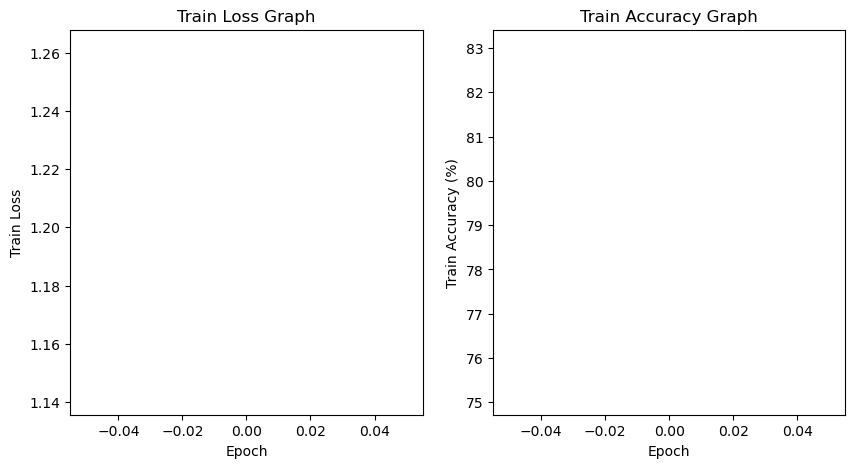

In [20]:
# Train Loss Graph
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_lst)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss Graph")

# Train Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(acc_lst)
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy (%)")
plt.title("Train Accuracy Graph")

# Inference

In [91]:
from torchvision.ops import roi_pool

vgg = models.vgg16_bn(weights="IMAGENET1K_V1", progress=True)

class FastRCNN_infer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load pre-trained VGG16
        # vgg = models.vgg16(weights="IMAGENET1K_V1")
        # Convolutional layers
        self.features = vgg.features
        # ROI Pooling
        self.roi = roi_pool
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            # nn.Linear(4096, num_classes),
        )
        self.softmax = nn.Linear(4096, num_classes + 1)
        self.bbox = nn.Linear(4096, num_classes * 4)
        
    def forward(self, images, ROIs):
        # Compute feature maps
        feature_maps = self.features(images)
        #print(feature_maps.shape)
        # Apply ROI pooling
        pooled_features = self.roi(feature_maps, ROIs, output_size=(7, 7), spatial_scale=1.0/16.0)
        #print(pooled_features.shape)
        # Flatten pooled features
        x = pooled_features.view(pooled_features.size(0), -1) # .size(0) = Batch Size(N)
        # x: [N, 512, 7, 7]
        # Classifier
        x = self.classifier(x) # x: [N, 4096]
        
        # Outputs
        cls_score = self.softmax(x) # (N, num_classes + 1)
        scores, labels = torch.max(cls_score, dim = 1) # (N, 1)
        mask = labels < 20 # (n, 1) non background number = n
        print(mask)
        fore_scores = scores[mask]
        fore_labels = labels[mask]
        masked_x = x[mask]
        print(f"fore_scores: {fore_scores}")
        print(f"fore_labels: {fore_labels}")
        
        offset_pred = self.bbox(masked_x) # (n, num_classes * 4)
        
        return cls_score, offset_pred, mask

In [162]:
def apply_bbox_regression(bboxes, offsets, labels):
    '''
    N = number of foreground proposals
    bboxes: [N, 4]
    offsets: [N, num_classes * 4]
    labels: [N]
    '''
    N = len(labels)
    num_classes = 20
    offsets = offsets.view(N, num_classes, 4)
    offsets = offsets[torch.arange(N), labels] # [N, 4]

    widths = bboxes[:, 2] - bboxes[:, 0]
    heights = bboxes[:, 3] - bboxes[:, 1]
    ctr_x = bboxes[:, 0] + (0.5 * widths)
    ctr_y = bboxes[:, 1] + (0.5 * heights)

    t_x = offsets[:, 0]
    t_y = offsets[:, 1]
    t_w = offsets[:, 2]
    t_h = offsets[:, 3]
    
    pred_ctr_x = t_x * widths + ctr_x
    pred_ctr_y = t_y * heights + ctr_y
    pred_widths = torch.exp(t_w) * widths
    pred_heights = torch.exp(t_h) * heights

    # Convert into xmin, ymin, xmax, ymax
    transformed_boxes = torch.zeros_like(bboxes)
    transformed_boxes[:, 0] = pred_ctr_x - (0.5 * widths)
    transformed_boxes[:, 1] = pred_ctr_y - (0.5 * heights)
    transformed_boxes[:, 2] = pred_ctr_x + (0.5 * widths)
    transformed_boxes[:, 3] = pred_ctr_y + (0.5 * heights)

    return transformed_boxes

In [163]:
import torchvision.ops as ops

def apply_nms(bboxes, scores, labels, nms_threshold=0.3):
    final_boxes = []
    final_scores = []
    final_labels = []
    unique_labels = labels.unique()

    for cls in unique_labels:
        cls_indices = (labels == cls)
        cls_boxes = bboxes[cls_indices]
        cls_scores = scores[cls_indices]
        cls_labels = labels[cls_indices]

        keep = ops.nms(cls_boxes, cls_scores, nms_threshold)
        final_boxes.extend(cls_boxes[keep])
        final_scores.extend(cls_scores[keep])
        final_labels.extend(cls_labels[keep])

    return final_boxes, final_scores, final_labels

In [164]:
def draw_gtbboxes(img_path, anno_path, proposals, scores, labels):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tree = ET.parse(anno_path)
    root = tree.getroot()
    gt_bboxes = parse_xml_boxes(root)

    # Draw GT bounding boxes
    for bbox in gt_bboxes:
        xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
        image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=2)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Draw proposal bounding boxes
    for idx, bbox in enumerate(proposals):
        x_min, y_min, width, height = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
        rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, f"{VOC_CLASSES[labels[idx]]} : {scores[idx]:.2f}", fontsize=8, bbox=dict(facecolor='yellow', alpha=1))
    return

In [165]:
transforamtion = v2.Compose([
    v2.ToImage(),  # Image to Tensor
    v2.ToDtype(torch.float32, scale=True), # Scaling Tensor [0~1]
    v2.Normalize(mean=VOC_VAL[0], std=VOC_VAL[1]) # Dataset Normalization
])

def inference(model, img_path, transform=None, device=DEVICE):
    '''
    Returns:
        final_boxes (list): List of final bounding boxes [x1, y1, x2, y2].
        final_labels (list): List of class labels corresponding to the boxes.
        final_scores (list): List of confidence scores corresponding to the boxes.
    '''
    model.eval()

    # Step 1: Load image
    image = Image.open(img_path)
    image = np.array(image)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    # Transform the image if appropriate
    if transform:
        image = transform(image)

    # Step 2: Selective Search
    squeezed_img = torch.squeeze(torch.tensor(image, dtype=torch.float32))
    ROIs = selective_search(squeezed_img.cpu().numpy())
    ROIs = torch.tensor(ROIs, dtype=torch.float32).to(device)
    # Tagging image tag
    batch_indices = torch.zeros((ROIs.size(0), 1), device=device)
    tagged_ROIs = torch.cat([batch_indices, ROIs], dim=1) # Shape: [num_proposals, 5] where 5 is [image, xmin, ymin, xmax, ymax]
    # (For reduced samping)
    random_idx = random.sample(range(tagged_ROIs.shape[0]), 2000)
    tagged_ROIs = tagged_ROIs[random_idx]
    
    # Step 3: Feed forward
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(dim=0).to(device)
    image = image.permute(0, 3, 1, 2)
    with torch.no_grad():
        cls_scores, offset_preds, mask = model(image, tagged_ROIs)
        # Get the class labels and scores
        scores, labels = torch.max(cls_scores, dim=1)
        
    # Filter out background class (assuming background class is 20)
    # (For reduced sampling)
    ROIs = ROIs[random_idx]

    pred_bboxes = ROIs[mask].cpu()
    scores = scores[mask].cpu()
    labels = labels[mask].cpu()
    offset_preds = offset_preds.cpu()
    
    if len(pred_bboxes) == 0:
        print("No objects detected")
        return [], [], []

    # Step 4: Apply bounding box regression to proposals
    transformed_boxes = apply_bbox_regression(pred_bboxes, offset_preds, labels)
    
    # Step 5: Apply class_independent NMS
    final_bboxes, final_scores, final_labels = apply_nms(transformed_boxes, scores, labels)
        
    return final_bboxes, final_scores, final_labels

In [23]:
fastrcnn_infer = FastRCNN_infer(20)
fastrcnn_infer.load_state_dict(torch.load('/Users/h383kim/pytorch/Fast-R-CNN/model_checkpoint.pth', map_location=torch.device('cpu')))
fastrcnn_infer = fastrcnn_infer.to(DEVICE)

/var/folders/n0/q19jqn7s6ts2t70bq5v6mhhc0000gn/T/ipykernel_1060/3467239934.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fastrcnn_infer.load_state_dict(torch.load('/Us

In [166]:
sample_path = '/Users/h383kim/pytorch/data/PASCAL_VOC_trainval/VOCdevkit/VOC2007/JPEGimages/000017.jpg'
ROIs, scores, labels = inference(fastrcnn_infer, sample_path)

tensor([False, False, False,  ..., False, False, False], device='mps:0')
fore_scores: tensor([41.1650, 18.0286,  6.1094, 42.4476, 14.6078, 17.0248, 21.1052, 21.3483,
        43.9650, 14.1546, 55.1699, 18.4482, 15.6179, 28.1681, 26.1738, 26.1738,
        42.2597, 19.1068, 31.4822, 24.0017, 20.6881,  7.9954, 14.1178, 15.9508,
        23.4027, 40.8946, 13.1490, 14.0685, 23.0419, 13.9389, 14.3626, 12.8309,
        40.4883, 12.2736, 23.6423, 46.0547, 18.4482,  8.1158, 40.8946, 44.9654,
        45.1502, 26.7667, 17.5573, 27.2724, 18.0023, 13.8297,  5.5627,  8.1158,
        17.3192, 13.7805, 21.5133,  3.8607, 31.9628,  6.6262, 45.2503, 10.6891,
        31.9628, 23.1216, 15.1642, 27.3239,  4.2987, 21.1052,  8.8088, 27.3917,
        53.3811, 30.7004, 21.9952, 53.0982, 37.3886, 23.0535, 11.7529, 39.9312,
        49.4334, 36.9141, 22.1425, 17.5035, 19.2936, 12.9272, 39.9312,  9.3200,
        30.7674, 26.7667, 12.1225, 27.2724, 45.4976, 28.1277, 31.9628, 26.7667,
        26.0088, 13.8681, 39.9312,

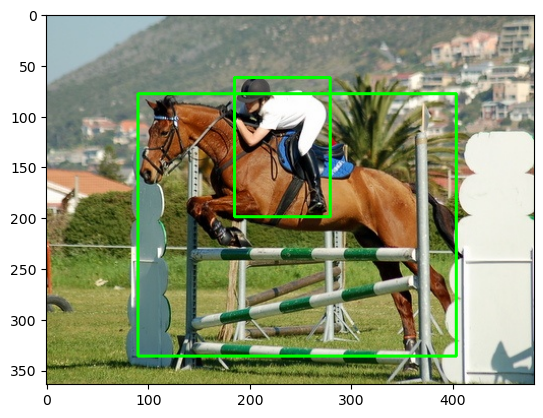

In [30]:
draw_gtbboxes(sample_path, '/Users/h383kim/pytorch/data/PASCAL_VOC_trainval/VOCdevkit/VOC2007/Annotations/000017.xml', [])

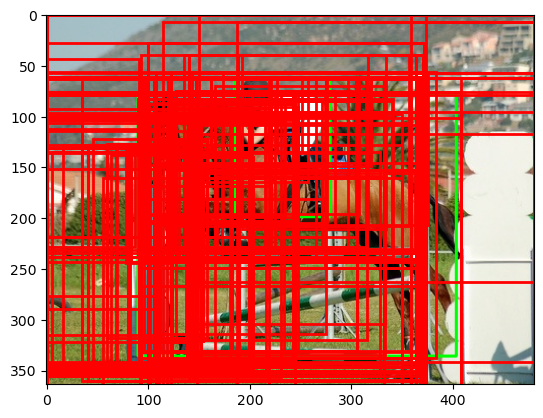

In [29]:
draw_gtbboxes(sample_path, '/Users/h383kim/pytorch/data/PASCAL_VOC_trainval/VOCdevkit/VOC2007/Annotations/000017.xml', cpu_ROIs)

In [68]:
import torchvision.ops as ops

def appy_nms(boxes, scores, labels, nms_threshold=0.3):
    final_boxes = []
    final_scores = []
    final_labels = []
    unique_labels = cpu_labels.unique()
    # Applying nms to each class independently
    for cls in unique_labels:
        cls_indices = (cpu_labels == cls)
        clsBoxes = cpu_ROIs[cls_indices]
        clsScores = cpu_scores[cls_indices]
        clsLabels = cpu_labels[cls_indices]
    
        nms_indices = ops.nms(clsBoxes, clsScores, nms_threshold)
        final_boxes.extend(clsBoxes[nms_indices])
        final_scores.extend(clsScores[nms_indices])
        final_labels.extend(clsLabels[nms_indices])
    
    return final_boxes, final_scores, final_labels
    

In [25]:
img = cv2.imread(sample_path)
img.shape

(364, 480, 3)

In [112]:
train_dataset[1]

(Image([[[-1.1247, -1.5357, -1.8097,  ..., -0.6623, -1.2788, -1.5528],
         [ 1.2214,  1.5639, -2.0494,  ..., -0.9705, -0.4226, -1.1247],
         [-1.7754, -0.8849, -1.5357,  ..., -1.5185, -2.0323, -1.1589],
         ...,
         [-0.7308, -1.3302, -0.8507,  ..., -1.9124, -1.8610, -1.8439],
         [-0.9192,  0.1597, -0.8678,  ..., -1.7925, -1.6727, -1.7583],
         [-0.7993, -0.4054, -1.3987,  ..., -1.8439, -1.7412, -1.7925]],
 
        [[-1.4230, -1.6856, -1.6681,  ..., -0.0399, -0.7227, -1.0203],
         [ 1.2731,  1.6933, -1.8256,  ..., -0.4076,  0.1352, -0.5826],
         [-1.2129, -0.3725, -1.1429,  ..., -1.0903, -1.4930, -0.5651],
         ...,
         [-0.2675, -0.8627, -0.3200,  ..., -1.7906, -1.7381, -1.7206],
         [-0.4951,  0.6254, -0.4076,  ..., -1.6681, -1.5455, -1.6331],
         [-0.5126, -0.0399, -0.9678,  ..., -1.7206, -1.6155, -1.6681]],
 
        [[-1.3339, -1.6127, -1.6302,  ..., -0.3055, -1.0027, -1.3164],
         [ 1.2805,  1.6988, -1.8044,  ..., 

In [56]:
len(cpu_ROIs)

209

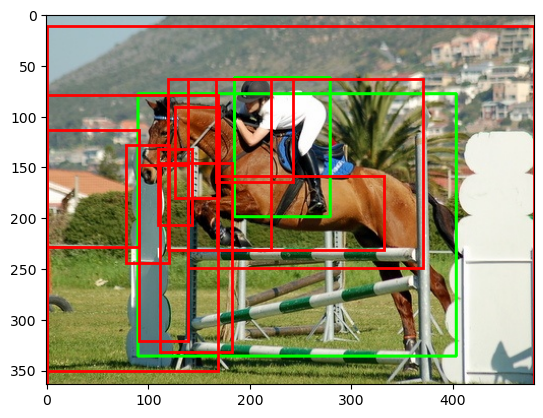

In [74]:
draw_gtbboxes(sample_path, '/Users/h383kim/pytorch/data/PASCAL_VOC_trainval/VOCdevkit/VOC2007/Annotations/000017.xml', ROIs)

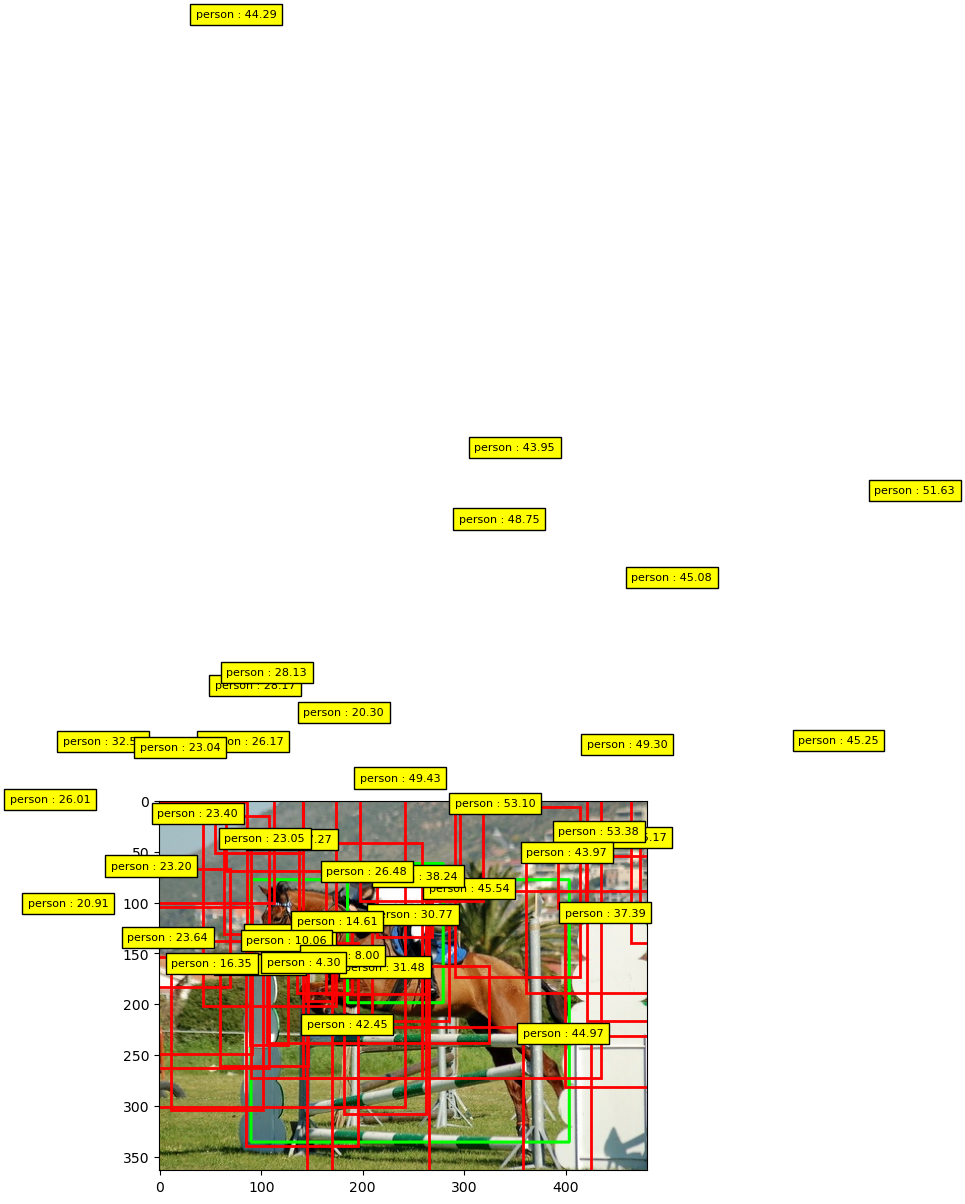

In [167]:
draw_gtbboxes(sample_path, '/Users/h383kim/pytorch/data/PASCAL_VOC_trainval/VOCdevkit/VOC2007/Annotations/000017.xml', ROIs, scores, labels)